## Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F

# sklearn
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

import contractions
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import re
import string
from tqdm import tqdm
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

stopwords = set(stopwords.words('english'))

c:\Users\fahrizain\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fahrizain\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
train = pd.read_csv('../data/processed/trainset-feature-extracted.csv')
test = pd.read_csv('../data/processed/testset-feature-extracted.csv')
len(train), len(test)

(159567, 153159)

In [3]:
test_used = test[test['is_toxic'] >= 0]
len(test_used)

63975

## Prepare Dataset

In [4]:
train_sent = train.processed.tolist()
test_sent = test.processed.tolist()

In [5]:
# get all processed texts
sentences = ' '.join(train_sent + test_sent)
# obtain list of words
words = sentences.split()

# check list
words[:10]

['explanation',
 'edits',
 'made',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'reverted',
 'vandalism',
 'closure']

In [6]:
# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

In [7]:
# filter and replace test set cz some of them aren't used for evaluation
test_sent = test_used.processed.to_list()
len(test_sent)

63975

In [8]:
# encode words
train_enc = [[word2int[word] for word in trsent.split()] for trsent in tqdm(train_sent)]
test_enc = [[word2int[word] for word in tssent.split()] for tssent in tqdm(test_sent)]

# look first 10 words of top-3 encoded sentences
for i in range(3):
    print(train_enc[i][:10])

100%|██████████| 63975/63975 [00:01<00:00, 54895.59it/s]

[516, 64, 57, 588, 3978, 8581, 699, 259, 128, 5520]
[5521, 1089, 322, 2480, 4319, 2381, 27, 6, 766, 2880]
[330, 266, 53, 173, 17, 175, 238, 2209, 408, 390]


In [9]:
# padding sequences

def pad_features(sentences, pad_id, seq_length=128):
    # make a template for output
    features = np.full((len(sentences), seq_length), pad_id, dtype=int)

    # trim sentence and assign paddings
    for i, row in enumerate(sentences):
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256

# pad features
train_features = pad_features(train_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)
test_features = pad_features(test_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(train_features) == len(train_enc)
assert len(train_features[0]) == seq_length
assert len(test_features) == len(test_enc)
assert len(test_features[0]) == seq_length

train_features[:3, :10]

array([[ 516,   64,   57,  588, 3978, 8581,  699,  259,  128, 5520],
       [5521, 1089,  322, 2480, 4319, 2381,   27,    6,  766, 2880],
       [ 330,  266,   53,  173,   17,  175,  238, 2209,  408,  390]])

In [10]:
# get labels as numpy
train_labels = train.is_toxic.to_numpy()
test_labels = test_used.is_toxic.to_numpy()
train_labels, test_labels

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([0, 0, 0, ..., 0, 1, 0], dtype=int64))

In [11]:
# get additional feature
train_fe = train.iloc[:, -2:].to_numpy()
test_fe = test_used.iloc[:, -2:].to_numpy()

In [12]:
# val size
val_size = .4

# get split index
all_idx = np.arange(len(train_features))
train_idx, val_idx = train_test_split(all_idx, test_size=val_size, random_state=42, stratify=train_labels)

# make train - val set
train_features, val_features = train_features[train_idx], train_features[val_idx]
train_labels, val_labels = train_labels[train_idx], train_labels[val_idx]
train_fe, val_fe = train_fe[train_idx], train_fe[val_idx]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_features.shape))
print('Validation set: {}'.format(val_features.shape))
print('Test set: {}'.format(test_features.shape))

Feature Shapes:
Train set: (95740, 256)
Validation set: (63827, 256)
Test set: (63975, 256)


In [13]:
# check data split proportion
print(len(train_labels[train_labels == 0]), len(train_labels[train_labels == 1]))
print(len(val_labels[val_labels == 0]), len(val_labels[val_labels == 1]))
print(len(test_labels[test_labels == 0]), len(test_labels[test_labels == 1]))

89821 5919
59881 3946
59574 4401


In [14]:
# define batch size
batch_size = 128

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_features), torch.from_numpy(train_labels))
valset = TensorDataset(torch.from_numpy(val_features), torch.from_numpy(val_labels))
testset = TensorDataset(torch.from_numpy(test_features), torch.from_numpy(test_labels))

# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(valset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [15]:
# check our batches
dataiter = iter(trainloader)
X, y = dataiter.next()

print('Sample batch size: ', X.size())      # batch_size, seq_length
print('Sample batch input: \n', X)
print()
print('Sample label size: ', y.size())      # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[  745,   129,    27,  ...,     0,     0,     0],
        [ 1150,    41,     7,  ...,     0,     0,     0],
        [   64, 41484,   101,  ...,     0,     0,     0],
        ...,
        [  973,   422,   129,  ...,     0,     0,     0],
        [  165,   331,     2,  ...,     0,     0,     0],
        [ 7188,   480,   450,  ...,     0,     0,     0]], dtype=torch.int32)

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0])


### Oversampling for Handle Imbalance Class

In [16]:
from collections import Counter

dataiter = iter(trainloader)
x = np.arange(11)
count_pos = []
count_neg = []

for i, (_, lbl) in enumerate(dataiter):
    c = Counter(lbl.numpy())
    count_pos.append(c[0])
    count_neg.append(c[1])
    if i >= 10:
        break

len(x), len(count_pos), len(count_neg)

(11, 11, 11)

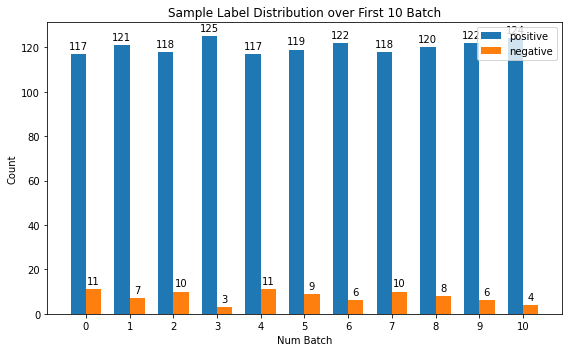

In [17]:
def plot_label_dist(batches, count_pos, count_neg, width=.35, title=None):
    width = width
    title = title if title != None else 'Sample Label Distribution over First 10 Batch'

    fig, ax = plt.subplots(figsize=(8,5))
    r1 = ax.bar(batches - width / 2, count_pos, width, label='positive')
    r2 = ax.bar(batches + width / 2, count_neg, width, label='negative')

    ax.set_ylabel('Count')
    ax.set_xlabel('Num Batch')
    ax.set_xticks(batches, batches)
    ax.set_title(title)
    ax.legend()

    ax.bar_label(r1, padding=3)
    ax.bar_label(r2, padding=3)

    fig.tight_layout()
    plt.show()

plot_label_dist(x, count_pos, count_neg)

In [18]:
labels_unique, counts = np.unique(train['is_toxic'], return_counts=True)
class_weights = [sum(counts) / c for c in counts]
example_weights = [class_weights[e] for e in train['is_toxic']]
sampler = WeightedRandomSampler(example_weights, len(train['is_toxic']))
sampler

In [19]:
# train sampler
train_counts = Counter(train_labels).values()
train_label_weights = [sum(train_counts) / c for c in train_counts]
train_sample_weights = [train_label_weights[e] for e in train_labels]
train_sampler = WeightedRandomSampler(train_sample_weights, len(train_labels))

# val sampler
val_counts = Counter(val_labels).values()
val_label_weights = [sum(val_counts) / c for c in val_counts]
val_sample_weights = [val_label_weights[e] for e in val_labels]
val_sampler = WeightedRandomSampler(val_sample_weights, len(val_labels))

In [20]:
# create oversampled dataloaders
trainloader = DataLoader(trainset, sampler=train_sampler, batch_size=batch_size)
# valloader = DataLoader(valset, sampler=val_sampler, batch_size=batch_size)

In [21]:
# check our batches
dataiter = iter(trainloader)
X, y = dataiter.next()

print('Sample batch size: ', X.size())      # batch_size, seq_length
print('Sample batch input: \n', X)
print()
print('Sample label size: ', y.size())      # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[   182,    104,    304,  ...,      0,      0,      0],
        [137999,    227,    168,  ...,      0,      0,      0],
        [    11,  36377,     11,  ...,      0,      0,      0],
        ...,
        [  1053,    872,     12,  ...,      0,      0,      0],
        [  2277, 161017,    224,  ...,      0,      0,      0],
        [    65,     62,     75,  ...,      0,      0,      0]],
       dtype=torch.int32)

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1])


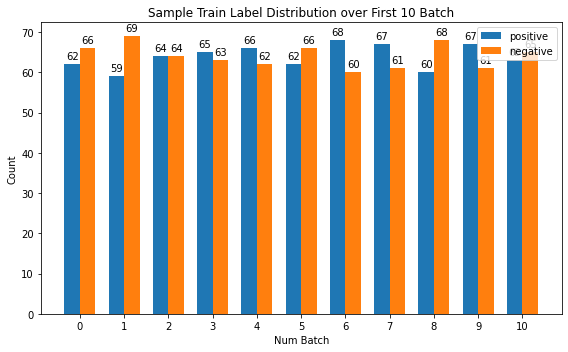

In [22]:
dataiter = iter(trainloader)
x = np.arange(11)
count_pos = []
count_neg = []

for i, (_, lbl) in enumerate(dataiter):
    c = Counter(lbl.numpy())
    count_pos.append(c[0])
    count_neg.append(c[1])
    if i >= 10:
        break

plot_label_dist(
    x, 
    count_pos, 
    count_neg,
    title='Sample Train Label Distribution over First 10 Batch')

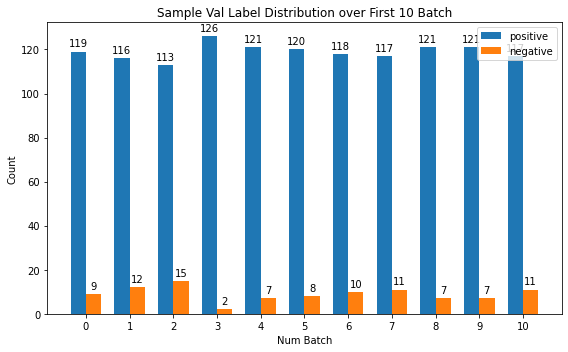

In [23]:
dataiter = iter(valloader)
count_pos = []
count_neg = []

for i, (_, lbl) in enumerate(dataiter):
    c = Counter(lbl.numpy())
    count_pos.append(c[0])
    count_neg.append(c[1])
    if i >= 10:
        break

plot_label_dist(
    x, 
    count_pos, 
    count_neg,
    title='Sample Val Label Distribution over First 10 Batch')

## Modelling
1. Build network architecture
2. Define model hyperparameters
3. Setup training config
4. Write training-validation loop
5. Plot Loss
6. Inference on test set
7. Evaluation metrics

In [24]:
# model architecture

class ToxicModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=300, n_layers=2, dropout=0.2):
        super(ToxicModel, self).__init__()

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # convert feature type to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, _ = self.lstm(x)

        # get last sequence output
        o = o[:, -1, :]

        # apply dropout and fully connected layer
        o = self.dropout(o)
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        return o

In [25]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [26]:
# model hyperparameters
vocab_size = len(word2int)
output_size = 1
embedding_size = 128
hidden_size = 128
n_layers = 2
dropout = 0.25

# model initialization
model = ToxicModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

ToxicModel(
  (embedding): Embedding(284429, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [27]:
# training config
lr = 0.0005 # 5e-4
criterion = nn.BCELoss() # we use BCELoss cz we have binary classification case
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 5
print_every = 1
history = {
    'train_precision': [],
    'train_recall': [],
    'train_fscore': [],
    'train_loss': [],
    'train_acc': [],
    'val_precision': [],
    'val_recall': [],
    'val_fscore': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5    # early stop

In [28]:
# train loop
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    model.train()

    train_loss = 0
    train_acc = 0
    train_precision = 0
    train_recall = 0
    train_fscore = 0

    for id, (feature, target) in enumerate(trainloader):
        # add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # move to device
        feature, target = feature.to(device), target.to(device)

        # reset optimizer
        optim.zero_grad()

        # forward pass
        out = model(feature)

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # move to cpu to calculate metrics
        target = target.cpu().numpy()

        # acc
        predicted = np.array([1 if i == True else 0 for i in out > 0.5])
        equals = predicted == target
        acc = np.mean(equals)
        train_acc += acc.item()

        # precision, recall, f_score
        train_precision += precision_score(target, predicted)
        train_recall += recall_score(target, predicted)
        train_fscore += f1_score(target, predicted)        

        # clip grad
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # update optimizer
        optim.step()

        # free some memory
        del feature, target, predicted
    
    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))
    history['train_precision'].append(train_precision / len(trainloader))
    history['train_recall'].append(train_recall / len(trainloader))
    history['train_fscore'].append(train_fscore / len(trainloader))

    ####################
    # validation model #
    ####################

    model.eval()

    val_loss = 0
    val_acc = 0
    val_precision = 0
    val_recall = 0
    val_fscore = 0

    with  torch.no_grad():
        for id, (feature, target) in enumerate(valloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')

            # move to device
            feature, target = feature.to(device), target.to(device)

            # forward pass
            out = model(feature)

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # move to cpu to calculate
            target = target.cpu().numpy()

            # acc
            predicted = np.array([1 if i == True else 0 for i in out > 0.5])
            equals = predicted == target
            acc = np.mean(equals)
            val_acc += acc.item()

            # precision, recall, f_score
            val_precision += precision_score(target, predicted)
            val_recall += recall_score(target, predicted)
            val_fscore += f1_score(target, predicted)            

            # free some memory
            del feature, target, predicted
        
    history['val_loss'].append(val_loss / len(valloader))
    history['val_acc'].append(val_acc / len(valloader))
    history['val_precision'].append(val_precision / len(valloader))
    history['val_recall'].append(val_recall / len(valloader))
    history['val_fscore'].append(val_fscore / len(valloader))

    # reset model mode
    model.train()

    # add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Recall: {val_recall / len(valloader):.3f}')

    # print epoch
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Recall: {train_recall / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Recall: {val_recall / len(valloader):.3f}')

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), '../models/toxic_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # force early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        # update epochs history
        history['epochs'] = e+1
        break

Training:   0%|          | 0/5 [04:52<?, ?it/s, Val Loss: 0.660 | Val F1: 0.282]

Epoch 1/5 | Train Loss: 0.661 Train F1: 0.431 | Val Loss: 0.660 Val F1: 0.282


Training:  40%|████      | 2/5 [10:23<15:44, 314.97s/it, Training batch 0/748]           

Epoch 2/5 | Train Loss: 0.636 Train F1: 0.360 | Val Loss: 0.661 Val F1: 0.105
[WARNING] Validation loss did not improved (0.660 --> 0.661)


Training:  40%|████      | 2/5 [15:56<15:44, 314.97s/it, Val Loss: 0.546 | Val F1: 0.293]

Epoch 3/5 | Train Loss: 0.615 Train F1: 0.504 | Val Loss: 0.546 Val F1: 0.293


Training:  60%|██████    | 3/5 [21:40<10:48, 324.26s/it, Val Loss: 0.245 | Val F1: 0.470]

Epoch 4/5 | Train Loss: 0.466 Train F1: 0.780 | Val Loss: 0.245 Val F1: 0.470


Training:  80%|████████  | 4/5 [27:24<05:32, 332.04s/it, Val Loss: 0.157 | Val F1: 0.650]

Epoch 5/5 | Train Loss: 0.166 Train F1: 0.943 | Val Loss: 0.157 Val F1: 0.650


Training: 100%|██████████| 5/5 [27:27<00:00, 329.41s/it, Val Loss: 0.157 | Val F1: 0.650]


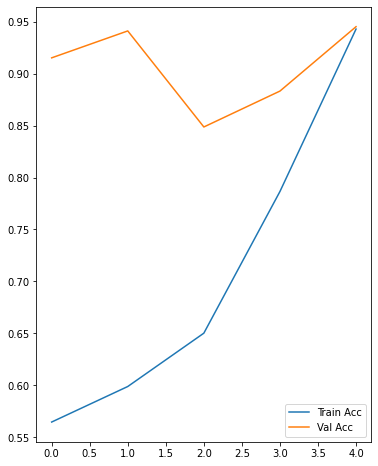

In [37]:
# plot acc
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

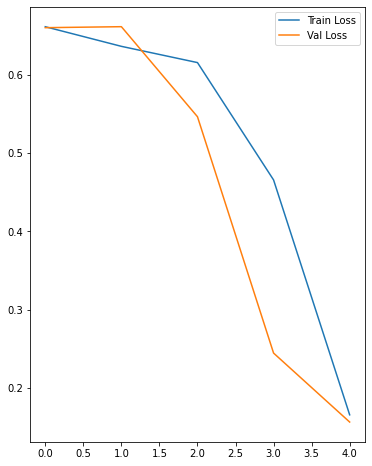

In [30]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

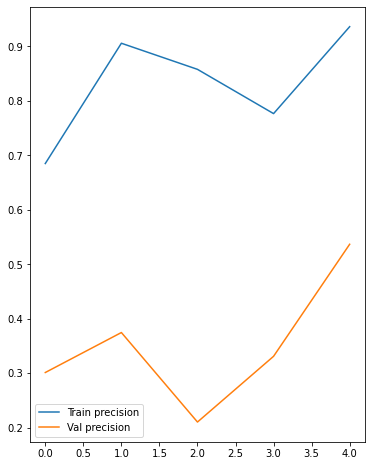

In [31]:
# plot precision
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_precision'], label='Train precision')
plt.plot(range(history['epochs']), history['val_precision'], label='Val precision')
plt.legend()
plt.show()

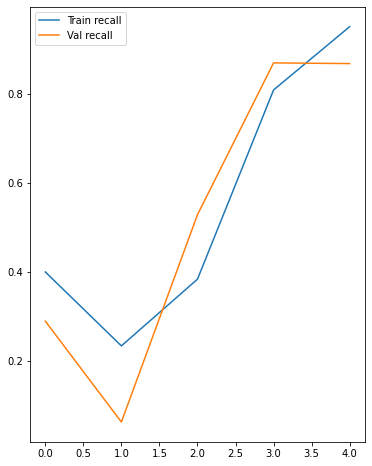

In [32]:
# plot recall
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_recall'], label='Train recall')
plt.plot(range(history['epochs']), history['val_recall'], label='Val recall')
plt.legend()
plt.show()

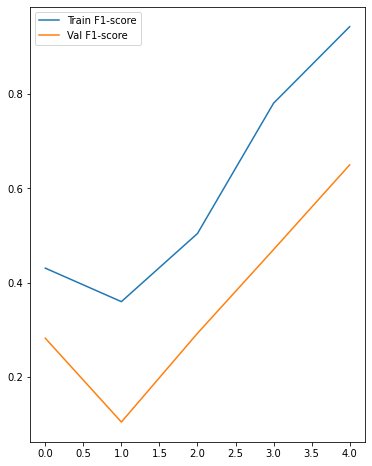

In [33]:
# plot fscore
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_fscore'], label='Train F1-score')
plt.plot(range(history['epochs']), history['val_fscore'], label='Val F1-score')
plt.legend()
plt.show()

## Inference

In [34]:
# test loop
model.eval()

# metrics
test_loss = 0
test_acc = 0
test_precision = 0
test_recall = 0
test_fscore = 0

all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)
        
        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        target = target.cpu().numpy()

        predicted = np.array([1 if i == True else 0 for i in out > 0.5])
        equals = predicted == target
        acc = np.mean(equals)
        test_acc += acc.item()        

        all_target.extend(target)
        all_predicted.extend(predicted)

    print(f'Accuracy: {test_acc / len(testloader):.4f}, Loss: {test_loss / len(testloader):.4f}')

print(f'Precision: {precision_score(all_target, all_predicted)}')
print(f'Recall: {recall_score(all_target, all_predicted)}')
print(f'F1 Score: {f1_score(all_target, all_predicted)}')

Inference: 100%|██████████| 500/500 [00:59<00:00,  8.46it/s]


Accuracy: 0.8876, Loss: 0.3196
Precision: 0.366062002111527
Recall: 0.8666212224494433
F1 Score: 0.5147098515519568


## Evaluation Metrics

In [35]:
print(classification_report(all_predicted, all_target))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     53556
           1       0.87      0.37      0.51     10419

    accuracy                           0.89     63975
   macro avg       0.88      0.68      0.73     63975
weighted avg       0.89      0.89      0.87     63975



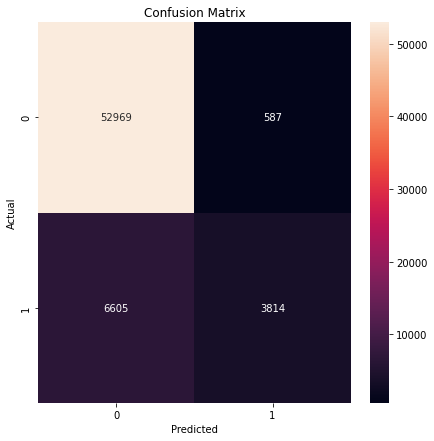

In [36]:
cm = confusion_matrix(all_predicted, all_target)
plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()